In [29]:
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import RDKFingerprint
from rdkit.Chem import PandasTools
from rdkit.Chem import AllChem
import csv


data_path = "C:/Users/vaclp/Desktop/MAMA AI/hERG_dataset.csv"
data = pd.read_csv(data_path)
data.head()


,smiles,activity
0,COc1ccc([C@@H](O)C[C@H]2c3cc(OC)c(OC)cc3CCN2C)cc1,1
1,Cc1nnc(N2CC[C@@H](F)C2)c2nn(-c3ccc(OCC(F)(F)F)...,1
2,O=c1n(Cc2ccccc2)c2sc3c(c2c2ncnn12)CCN(CC1CCOCC...,1
3,COCCCc1cc(CN(C(=O)[C@H]2CNCC[C@@H]2c2ccc(OCCOc...,1
4,CC1(C)C2=C3C=C4C5=[N+](CCC4OC3CCN2c2ccc(CC(=O)...,1


In [30]:
# I. DATA PREPARATION (- Morgan fingeprints)
smiles_list = data["smiles"].tolist()

In [31]:
# putting SMILES in lists
molecules = [Chem.MolFromSmiles(smiles) for smiles in smiles_list]

In [32]:
# transforming SMILES to Morgan fingerprints
fingerprints = [(AllChem.GetMorganFingerprintAsBitVect(mol, 4, nBits = 2048).ToBitString()) for mol in molecules]

In [33]:
data.head(1)

,smiles,activity
0,COc1ccc([C@@H](O)C[C@H]2c3cc(OC)c(OC)cc3CCN2C)cc1,1


In [34]:
data.insert(2, 'Morgan_FPS', fingerprints)
data.head(1)

,smiles,activity,Morgan_FPS
0,COc1ccc([C@@H](O)C[C@H]2c3cc(OC)c(OC)cc3CCN2C)cc1,1,0100000000000000000000000000000000000000000000...


In [35]:
# Morgan fingerprints as numpy arrays
numpy_fps = data['Morgan_FPS'].apply(lambda x: pd.Series(list(x)))
fps_devided_np = np.array(numpy_fps)
fps_devided_np = fps_devided_np.astype(np.int64) # str to int64
fps_devided_np

array([[0, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0]], dtype=int64)

In [36]:
pd.DataFrame(fps_devided_np).to_csv("C:/Users/vaclp/Desktop/MAMA AI/numpy_FPS.csv")

In [37]:
# concatting original dataset file and numpy arrays (Morgan fingerprints)
data_final = pd.concat([data, pd.DataFrame(fps_devided_np)], axis=1)
data_final.head(1)

,smiles,activity,Morgan_FPS,0,1,2,3,4,5,6,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
0,COc1ccc([C@@H](O)C[C@H]2c3cc(OC)c(OC)cc3CCN2C)cc1,1,0100000000000000000000000000000000000000000000...,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [38]:
# dropping "smiles" and "morgan_fps" columns 
drop_list = ["smiles", "Morgan_FPS"]
ColumnFilter = data_final.filter(drop_list)
data_final.drop(ColumnFilter, inplace=True, axis=1)
data_final.to_csv("C:/Users/vaclp/Desktop/MAMA AI/data_final.csv")

In [39]:
data_final.shape

(8154, 2049)

In [40]:
data_final.head(5)

,activity,0,1,2,3,4,5,6,7,8,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
0,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
4,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [41]:
# II. MACHINE LEARNING MODELS 
# target defining for modeling

from sklearn.model_selection import train_test_split


X = data_final.copy()
y = X.pop("activity")

# splitting the data set
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, train_size=0.8)


In [42]:
# radial Support Vector Machine model

from sklearn import svm, metrics
import shap


SVM_model=svm.SVC(kernel='rbf',gamma="scale", probability=True)
SVM_model.fit(X_train,y_train)

y_prediction = SVM_model.predict(X_test)

print('Accuracy for rbf SVM is ', metrics.accuracy_score(y_prediction,y_test))

Accuracy for rbf SVM is  0.8933169834457388


In [43]:
# Decision Tree model

from sklearn.tree import DecisionTreeClassifier


dec_tree = DecisionTreeClassifier()
dec_tree = dec_tree.fit(X_train, y_train)

y_prediction = dec_tree.predict(X_test)

print('Accuracy for DT is ', metrics.accuracy_score(y_prediction,y_test))

Accuracy for DT is  0.8338442673206622


Minimum validation loss: 0.12827597558498383
Accuracy: 0.9028054475784302


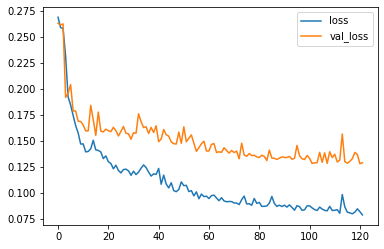

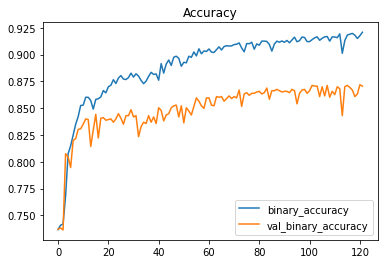

In [44]:
# Neural Network model

from tensorflow import keras
from tensorflow.keras import callbacks
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt


NN_model = keras.Sequential([
   
    layers.Dense(units=512, activation='relu', input_shape=[2048]),
    layers.Dense(units=192, activation='relu'),
    layers.Dense(units=64, activation='relu'),
    layers.Dropout(rate = 0.4),
    layers.Dense(units=1, activation='sigmoid'),
])


early_stopping = EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=20, # how many epochs to wait before stopping
    restore_best_weights=True,
)


NN_model.compile(optimizer='adam', 
                 loss='mae',
                 metrics=['binary_accuracy'],
)


history = NN_model.fit(
    X_train, y_train, 
    validation_data= (X_test, y_test),
    epochs=256, 
    batch_size=30,
    callbacks=[early_stopping],
    verbose=0,
)


history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
history_df.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot(title="Accuracy")
print("Minimum validation loss: {}".format(history_df['val_loss'].min()))
print("Accuracy: {}".format(history_df['binary_accuracy'].median())) # blue=train, yellow=test (validation)

In [45]:
import warnings


warnings.filterwarnings('ignore')

In [178]:
# III. Shapley Additive Explanations (SHAP) values
#Defining a dataset used for calculating SHAP values (30 molecules for the calculation)

X_test_sample = X_test.iloc[:30,:] 

In [219]:
# SHAP values 

import shap
import matplotlib.pyplot as plt


#Desicion Tree - SHAP values calculation:
explainer = shap.KernelExplainer(dec_tree.predict,X_test_sample)
shap_values = explainer.shap_values(X_test_sample)

  0%|          | 0/30 [00:00<?, ?it/s]

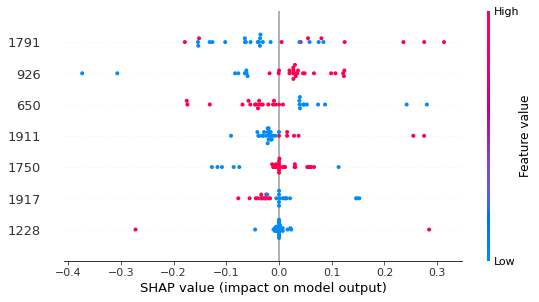

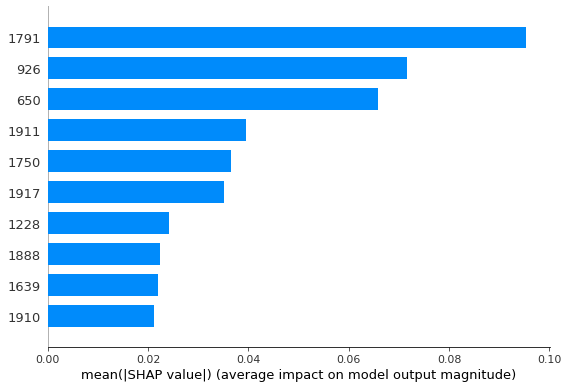

In [221]:
# Decision Tree - SHAP plots
shap.summary_plot(shap_values, X_test_sample, max_display=7) # overall picture of top -/+ influence on (activity) prediction
shap.summary_plot(shap_values, X_test_sample, plot_type='bar', show=True, max_display=10)

In [222]:
shap_values_dc_df = pd.DataFrame(shap_values).to_csv("C:/Users/vaclp/Desktop/MAMA AI/SHAPVAL/shap_values_dc.csv")

In [223]:
# Support Vectore Machine - SHAP values calculation:
explainer = shap.KernelExplainer(SVM_model.predict,X_test_sample)
shap_values = explainer.shap_values(X_test_sample)

  0%|          | 0/30 [00:00<?, ?it/s]

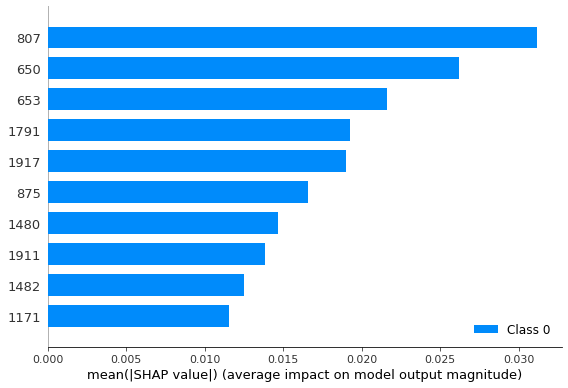

In [274]:
# Support Vectore Machine - SHAP plots
shap.summary_plot(shap_values, X_test_sample, plot_type='bar', show=True, max_display=10)

In [225]:
shap_values_svm_df = pd.DataFrame(shap_values).to_csv("C:/Users/vaclp/Desktop/MAMA AI/SHAPVAL/shap_values_svm.csv")

In [227]:
# Neural Network - SHAP values calculation:
explainer = shap.KernelExplainer(NN_model,X_test_sample)
shap_values = explainer.shap_values(X_test_sample)

  0%|          | 0/30 [00:00<?, ?it/s]

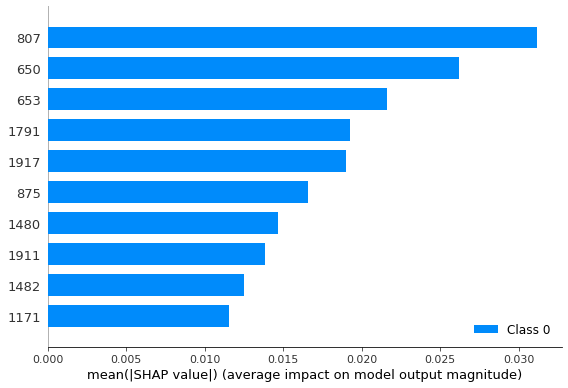

In [244]:
# Neural Network - SHAP plots
shap.summary_plot(shap_values, X_test_sample, plot_type='bar', show=True, max_display=10)

In [230]:
shap_values_nn_df = pd.DataFrame(shap_values[0]).to_csv("C:/Users/vaclp/Desktop/MAMA AI/SHAPVAL/shap_values_nn.csv")